<a href="https://colab.research.google.com/github/kamalzada/target_encoding/blob/master/Target_kfold_enc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target Encoding with Cross Validation: Alternative to One-hot-encoding

In [2]:
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn import base
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

In [103]:
raw = pd.read_csv('hotelbookingsinfo.csv', usecols=['reserved_room_type', 'leadtime'])
df = deepcopy(raw) 

In [104]:
df['reserved_room_type'].nunique() 

10

In [5]:
df['leadtime'] #target 

0         342
1         737
2           7
3          13
4          14
         ... 
119385     23
119386    102
119387     34
119388    109
119389    205
Name: leadtime, Length: 119390, dtype: int64

In [105]:
table = pd.pivot_table(data=df, index='reserved_room_type', aggfunc=[np.mean, 'count'])
table #checking the ones to be encoded 

,mean,count
,leadtime,leadtime
reserved_room_type,,
A,110.940240,85994
B,113.268336,1118
C,80.173820,932
D,86.829488,19201
E,91.121500,6535
F,68.529168,2897
G,80.248329,2094
H,78.387687,601


In [106]:
df = df.loc[(df['reserved_room_type']!='L') & (df['reserved_room_type']!='P')] 

In [107]:
X = df.drop('leadtime', axis=1) 
y = df.leadtime
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=29) #to prevent data leakage

In [108]:
X_train['reserved_room_type'].value_counts()

A    68836
D    15311
E     5262
F     2282
G     1687
B      888
C      747
H      484
Name: reserved_room_type, dtype: int64

In [109]:
X_test['reserved_room_type'].value_counts() #split

A    17158
D     3890
E     1273
F      615
G      407
B      230
C      185
H      117
Name: reserved_room_type, dtype: int64

In [110]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [111]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):
   
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=False,
                  discardOriginal_col=True):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):        
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)       
        
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True)        
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan       
        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)  #Fill in the place that has become nan with the global mean
            
        if self.verbosity:            
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName, 
                                                                                  np.corrcoef(X[self.targetName].values,encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.colnames, axis=1)
        return X

In [112]:
kfoldtrain = KFoldTargetEncoderTrain('reserved_room_type', 'leadtime')  
kfoldtrain.fit_transform(df_train)
kfoldtrain.fit_transform(df_test)  #when you have a target in your test data 

,leadtime,reserved_room_type_Kfold_Target_Enc
95567,79,91.454545
14986,166,110.823872
59011,468,110.823872
59292,21,110.823872
38506,35,70.262626
...,...,...
12315,331,110.823872
86073,5,86.265670
12827,39,111.634466
115423,10,111.634466


In [113]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin): 
    
    def __init__(self,train,colNames,encodedName):
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        X[self.encodedName] = X[self.colNames]
        X.replace({self.encodedName: dd}, inplace=True)
        return X

In [114]:
df_test_no_target = deepcopy(df_test) #when you have no target in your test data
df_test_no_target.drop('reserved_room_type_Kfold_Target_Enc', axis=1, inplace=True)

In [115]:
test_targetc = KFoldTargetEncoderTest(df_train, 'reserved_room_type', 'reserved_room_type_Kfold_Target_Enc')
test_targetc.fit_transform(df_test_no_target)  

,reserved_room_type,leadtime,reserved_room_type_Kfold_Target_Enc
95567,E,79,91.030262
14986,A,166,110.964252
59011,A,468,110.964252
59292,A,21,110.964252
38506,F,35,68.019858
...,...,...,...
12315,A,331,110.964252
86073,D,5,86.763323
12827,A,39,110.964252
115423,A,10,110.964252


In [116]:
display(df_test['reserved_room_type_Kfold_Target_Enc'].nunique(),
df_test_no_target['reserved_room_type_Kfold_Target_Enc'].nunique()) 

40

8

In [145]:
df_test['leadtime'].corr(df_test['reserved_room_type_Kfold_Target_Enc']) 
#the encoded feature still has a weak correlation to the target 

0.10612235026305805

In [139]:
df_train['leadtime'].corr(df_train['reserved_room_type_Kfold_Target_Enc'])

0.11084739825075945

In [102]:
df_test_no_target['leadtime'].corr(df_test_no_target['reserved_room_type_Kfold_Target_Enc'])

0.10802410935970537

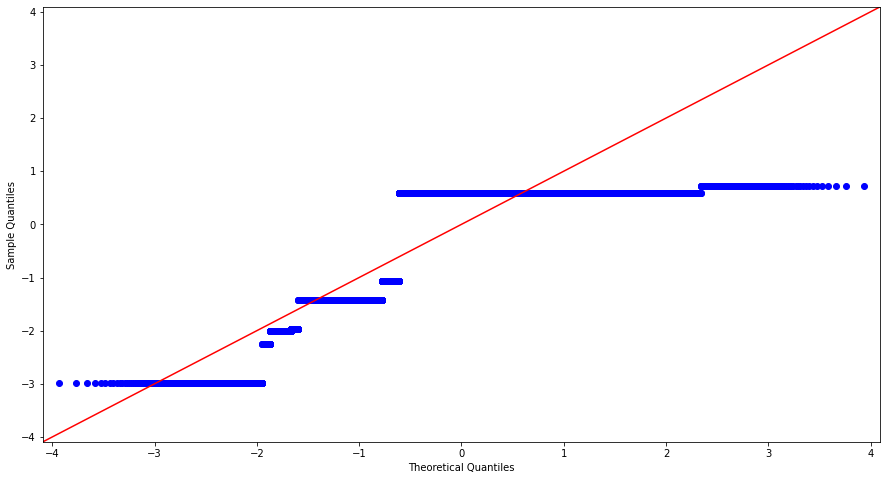

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
fig = qqplot(df_test_no_target['reserved_room_type_Kfold_Target_Enc'], line = '45', fit=True)
ax = plt.gca()   
fig.set_size_inches(15, 8) 
plt.show() #Distribution of newly target encoded feature

In [140]:
class handle_vif():
    
    def __init__(self, data):
        self.data = data
        
    def compute_vif(self, considered_features: list):
        self.considered_features = considered_features
        X = self.data[self.considered_features]
        X['intercept'] = 1
        
        self.vif = pd.DataFrame()
        self.vif["Variable"] = X.columns
        self.vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        self.vif = self.vif[self.vif['Variable']!='intercept']
        return self.vif
    
    def drop_high_vif(self):
        self.vif_table = self.vif.sort_values(by='VIF', ascending=False).reset_index(drop=True) 
    
        while self.vif_table['VIF'].iloc[0]>5:
            self.data.drop(self.vif_table['Variable'][0], axis=1, inplace=True)
            computed = compute_vif([col for col in self.data.columns]) 
            self.vif_table = computed.sort_values(by='VIF', ascending=False).reset_index(drop=True) 

        return self.data.head()  

In [143]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [144]:
vif = handle_vif(df_train) 
vif.compute_vif(['reserved_room_type_Kfold_Target_Enc', 'leadtime']) #checking variance inflation factor  

,Variable,VIF
0,reserved_room_type_Kfold_Target_Enc,1.01244
1,leadtime,1.01244
